In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
weather = pd.read_csv('../datasets/weather.csv')
spray = pd.read_csv('../datasets/spray.csv')

In [3]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [18]:
train['Date'].value_counts()

2007-08-01    551
2007-08-15    276
2013-08-01    186
2007-08-24    186
2007-08-21    186
             ... 
2007-10-09     26
2007-05-29     25
2007-09-25     23
2009-06-03     14
2007-08-03      5
Name: Date, Length: 95, dtype: int64

In [4]:
train['year'] = train['Date'].apply(lambda x: int(x.split('-')[0]))

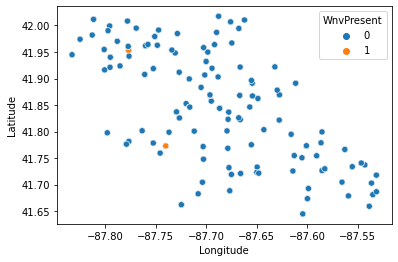

In [5]:
sns.scatterplot(data=train[train['year'] == 2007], x='Longitude', y='Latitude', hue='WnvPresent');

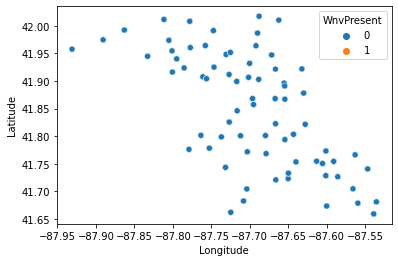

In [6]:
sns.scatterplot(data=train[train['year'] == 2009], x='Longitude', y='Latitude', hue='WnvPresent');

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

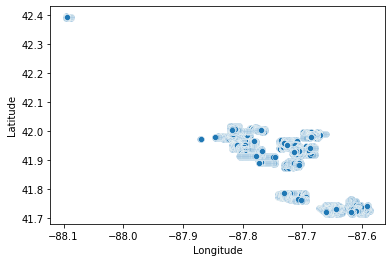

In [7]:
sns.scatterplot(data=spray, x='Longitude', y='Latitude')

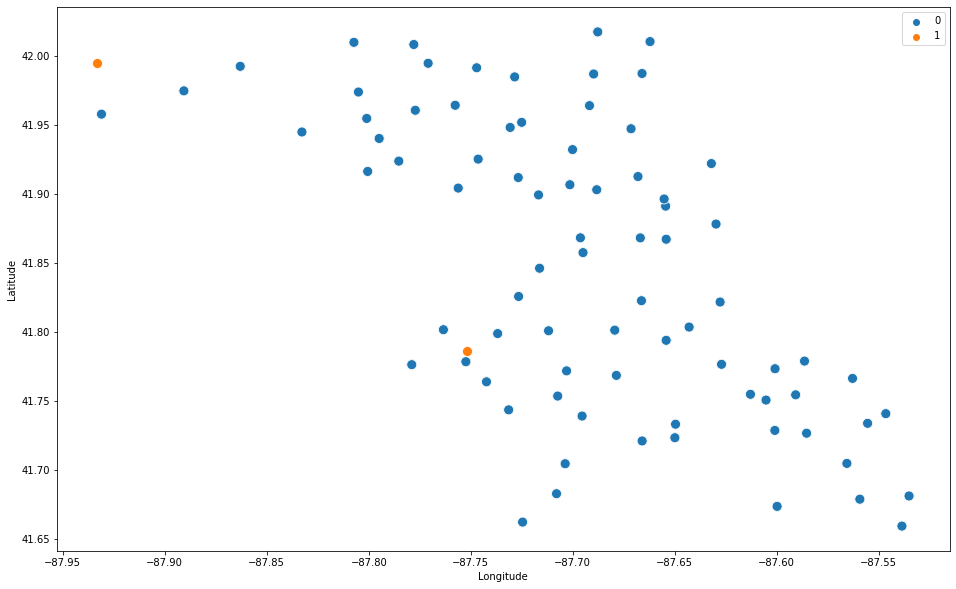

In [14]:
plt.figure(figsize=(16,  10))
sns.scatterplot(data=train[train['year'] == 2011], x='Longitude', y='Latitude', hue='WnvPresent', s=100)
# sns.scatterplot(data=spray, x='Longitude', y='Latitude')
sns.scatterplot(data=weather, x='Longitude', y='Latitude', s=100);

In [11]:
weather['Latitude'] = weather['Station'].apply(lambda x: 41.995 if x == 1 else 41.786)
weather['Longitude'] = weather['Station'].apply(lambda x: -87.933 if x == 1 else -87.752)

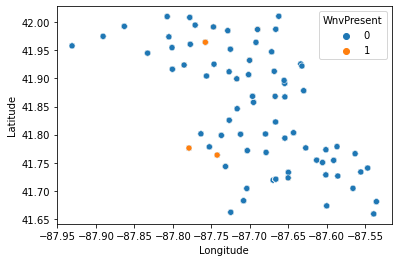

In [12]:
sns.scatterplot(data=train[train['year'] == 2013], x='Longitude', y='Latitude', hue='WnvPresent');

In [15]:
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude,Longitude
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,M,0.0,0.00,29.10,29.82,1.7,27,9.2,41.995,-87.933
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,M,M,0.00,29.18,29.82,2.7,25,9.6,41.786,-87.752
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,M,0.0,0.00,29.38,30.09,13.0,4,13.4,41.995,-87.933
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,M,M,0.00,29.44,30.08,13.3,2,13.4,41.786,-87.752
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,M,0.0,0.00,29.39,30.12,11.7,7,11.9,41.995,-87.933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,M,M,0.00,29.42,30.07,8.5,29,9.0,41.786,-87.752
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,M,0.0,0.00,29.34,30.09,5.1,24,5.5,41.995,-87.933
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,M,M,T,29.41,30.10,5.9,23,6.5,41.786,-87.752
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,M,0.1,0.03,29.49,30.20,22.6,34,22.9,41.995,-87.933
